In [2]:
import tweepy
import json
import re
import arrow
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from pytz import timezone
from dateutil.parser import parse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import davies_bouldin_score
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

In [3]:
trump = pd.read_csv('trump_basic_sentiment.csv')
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,text_cleaned,tb_polarity,tb_subjectivity,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,the only thing get wrong be that be even bad t...,-0.412500,0.825000,negative,subjective,0.373,0.627,0.000,-0.8786,negative
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,vote by may opponent vote to fire teacher and ...,1.000000,0.750000,positive,subjective,0.205,0.671,0.123,-0.4168,negative
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,be strong on crime the border and second amend...,0.088889,0.397222,positive,objective,0.072,0.740,0.189,0.6885,positive
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,tom tiffany be a great advocate for the incred...,0.541667,0.633333,positive,subjective,0.046,0.640,0.314,0.9439,positive
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,over million economic impact payment have alre...,0.250000,0.400000,positive,objective,0.000,1.000,0.000,0.0000,neutral


In [4]:
corpus = trump['text_cleaned'].values
corpus

array(['the only thing get wrong be that be even bad the corruption than think jordan dirty cops',
       'vote by may opponent vote to fire teacher and cut salary while bump up pay now mock great vet need navy fighter pilot mike garcia in',
       'be strong on crime the border and second amendment tom have deep root in wisconsin be a big tax cutter and will help drain the swamp tom have complete and total endorsement vote for tom tiffany',
       ..., 'everyone very excited about the new deal with mexico',
       'nervous nancy pelosi the democrat house be get nothing do perhaps could lead the way with the usmca the spectacular very popular new trade deal that replace nafta the bad trade deal in the history of the u s a great for farmer manufacturer union',
       'mexico have agree to immediately begin buy large quantity of agricultural product from great patriot farmer'],
      dtype=object)

In [5]:
# tf idf 
vectorizer = TfidfVectorizer(
    min_df = 5,
    stop_words = 'english' # remove stop words
)
tfidf = vectorizer.fit_transform(corpus)
tfidf.shape

(4739, 1850)

# k-means

In [6]:
# MiniBatchKMeans is much faster than KMeans at the expense of accuracy
# though, its result is still comparable to KMeans
# it is a good algo to find the optimal k value for KMeans
# here we choose k=26
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    dbindex = []
    for k in iters:
        c = MiniBatchKMeans(n_clusters=k, batch_size=3000, random_state=20).fit(data)
        sse.append(c.inertia_)
        db = davies_bouldin_score(data.todense(), c.labels_)
        dbindex.append(db)
        print('n_clusters = {0}, dbindex = {1}'.format(k, db))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, dbindex, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('DB Index')
    ax.set_title('DB Index by Cluster Center Plot')

n_clusters = 2, dbindex = 10.41516147731686
n_clusters = 4, dbindex = 7.564190908174444
n_clusters = 6, dbindex = 8.712766822929945
n_clusters = 8, dbindex = 8.670277541448343
n_clusters = 10, dbindex = 8.546118052050465
n_clusters = 12, dbindex = 7.334934843424052
n_clusters = 14, dbindex = 7.577350199077243
n_clusters = 16, dbindex = 7.104237781953357
n_clusters = 18, dbindex = 6.886055490601515
n_clusters = 20, dbindex = 6.492852628599108
n_clusters = 22, dbindex = 6.221419756760143
n_clusters = 24, dbindex = 6.021023047911609
n_clusters = 26, dbindex = 5.59627125864285
n_clusters = 28, dbindex = 5.835343136520928
n_clusters = 30, dbindex = 2.06089326071533


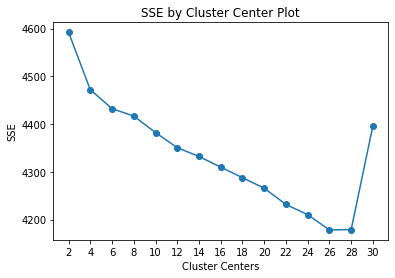

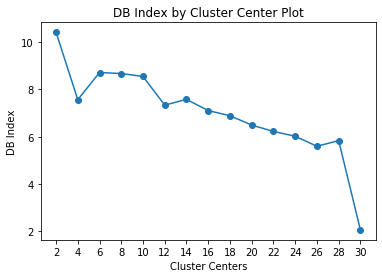

In [7]:
find_optimal_clusters(tfidf, 30)

In [ ]:
k_clusters = KMeans(n_clusters=26, random_state=20, verbose=1).fit_predict(tfidf)

In [9]:
def get_cluster_counts(clusters):
    counts = {}
    for i in np.stack([np.unique(clusters, return_counts=True)]).T:
        counts['Cluster {}'.format(i[0][0])] = i[1][0]
    for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True):
        print('{0}: {1}'.format(k, v))

In [10]:
get_cluster_counts(k_clusters)

Cluster 1: 1429
Cluster 2: 307
Cluster 4: 272
Cluster 3: 252
Cluster 20: 202
Cluster 12: 197
Cluster 10: 179
Cluster 6: 166
Cluster 15: 165
Cluster 25: 161
Cluster 5: 151
Cluster 24: 151
Cluster 18: 145
Cluster 7: 142
Cluster 8: 128
Cluster 23: 120
Cluster 13: 118
Cluster 17: 92
Cluster 21: 59
Cluster 22: 57
Cluster 11: 55
Cluster 14: 47
Cluster 0: 40
Cluster 19: 39
Cluster 9: 36
Cluster 16: 29


In [11]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    for i,r in df.iterrows():
        print('Cluster {}: '.format(i), 
              ', '.join([labels[t] for t in np.argsort(r)[-n_terms:][::-1]]))
        print(np.sort(r)[-n_terms:][::-1])
        print()

In [12]:
get_top_keywords(tfidf, k_clusters, vectorizer.get_feature_names(), 10)

Cluster 0:  happy, birthday, day, great, thanksgiving, new, national, melania, year, america
[0.49314388 0.23632121 0.08020015 0.05158134 0.0411259  0.02839884
 0.02656095 0.02459068 0.02353745 0.02319482]

Cluster 1:  people, country, thank, like, bad, big, look, way, make, just
[0.01664859 0.01473339 0.01457298 0.01372398 0.01355594 0.01313094
 0.01288102 0.01222454 0.01154207 0.01118433]

Cluster 2:  great, job, thank, honor, country, congratulation, work, guy, people, tonight
[0.28117655 0.0573572  0.04665573 0.02851155 0.02063138 0.02004706
 0.01820058 0.01699178 0.01625922 0.01608168]

Cluster 3:  president, trump, say, year, obama, country, ukraine, democrats, know, happen
[0.19191535 0.1148634  0.03498098 0.0241541  0.02369737 0.02272187
 0.02272177 0.0226917  0.02213998 0.02199293]

Cluster 4:  news, fake, medium, conference, white, corrupt, story, house, great, say
[0.23105825 0.19633416 0.06646447 0.04489526 0.03413844 0.03375135
 0.03059789 0.03000858 0.02691779 0.02553096]

In [33]:
davies_bouldin_score(tfidf.todense(), k_clusters)

5.296897821360359

In [13]:
trump['k_cluster'] = k_clusters
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_polarity,tb_subjectivity,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,-0.412500,0.825000,negative,subjective,0.373,0.627,0.000,-0.8786,negative,1
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,1.000000,0.750000,positive,subjective,0.205,0.671,0.123,-0.4168,negative,1
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,0.088889,0.397222,positive,objective,0.072,0.740,0.189,0.6885,positive,17
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.541667,0.633333,positive,subjective,0.046,0.640,0.314,0.9439,positive,2
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,0.250000,0.400000,positive,objective,0.000,1.000,0.000,0.0000,neutral,1


In [14]:
trump.to_pickle('temp.pkl') 

# HDBSCAN

In [14]:
def find_optimal_min_cluster_size(data):
    cluster_size = []
    cluster_count = []
    dbindex = []
    for i in range(10, 100, 5):
        h = hdbscan.HDBSCAN(min_cluster_size=i).fit(data)
        if h.labels_.max() <= 0:
            break
        db = davies_bouldin_score(data.todense(), h.labels_)
        dbindex.append(db)
        cluster_size.append(i)
        cluster_count.append(h.labels_.max()+1)
        print('min_cluster_size = {}, dbindex = {}'.format(i, db))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(cluster_size, cluster_count, marker='o')
    ax.set_xlabel('Cluster Size')
    ax.set_xticks(cluster_size)
    ax.set_xticklabels(cluster_size)
    ax.set_ylabel('Cluster Count')
    ax.set_title('Cluster Count Plot')
    
    f, ax = plt.subplots(1, 1)
    ax.plot(cluster_size, dbindex, marker='o')
    ax.set_xlabel('Cluster Size')
    ax.set_xticks(cluster_size)
    ax.set_xticklabels(cluster_size)
    ax.set_ylabel('DB Index')
    ax.set_title('DB Index Plot')

min_cluster_size = 10, dbindex = 10.163745521625389
min_cluster_size = 15, dbindex = 13.571012167158305
min_cluster_size = 20, dbindex = 17.417299810549903
min_cluster_size = 25, dbindex = 17.916669572928498
min_cluster_size = 30, dbindex = 20.0930699327663
min_cluster_size = 35, dbindex = 11.62301107589204
min_cluster_size = 40, dbindex = 7.146855331501106
min_cluster_size = 45, dbindex = 4.619133223462665


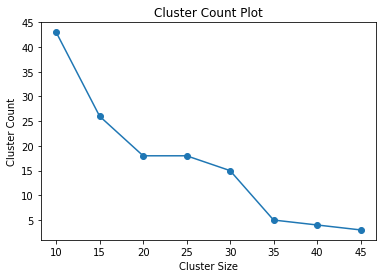

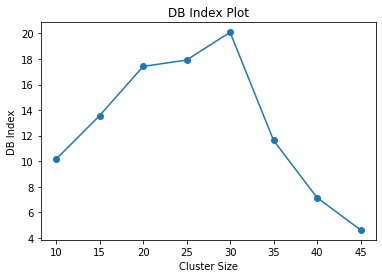

In [15]:
# find the optimal size of min_cluster_size
# expected using data from at least 0.2% to 2% of the total to form a cluster
# here we choose min_cluster_size = 15
find_optimal_min_cluster_size(tfidf)

In [16]:
h_clusters = hdbscan.HDBSCAN(min_cluster_size=15).fit(tfidf)

In [17]:
get_cluster_counts(h_clusters.labels_)

Cluster 5: 1189
Cluster 11: 804
Cluster 0: 778
Cluster -1: 377
Cluster 9: 292
Cluster 13: 223
Cluster 2: 181
Cluster 15: 144
Cluster 24: 110
Cluster 7: 70
Cluster 10: 70
Cluster 12: 52
Cluster 4: 51
Cluster 20: 50
Cluster 1: 49
Cluster 19: 45
Cluster 22: 42
Cluster 6: 29
Cluster 8: 28
Cluster 16: 26
Cluster 25: 25
Cluster 18: 23
Cluster 17: 17
Cluster 21: 17
Cluster 3: 16
Cluster 23: 16
Cluster 14: 15


In [18]:
get_top_keywords(tfidf, h_clusters.labels_, vectorizer.get_feature_names(), 10)

Cluster -1:  thank, great, news, fake, job, maga, work, book, people, say
[0.06028478 0.05671699 0.04817332 0.03773606 0.02679588 0.02618596
 0.02351134 0.01997906 0.01876852 0.01489499]

Cluster 0:  great, people, president, country, good, job, make, democrats, just, want
[0.03814479 0.02442994 0.02272992 0.01937386 0.01937169 0.01933473
 0.01932372 0.0178648  0.0174107  0.01730383]

Cluster 1:  time, impeachment, great, senate, pelosi, republican, hoax, total, dem, trial
[0.04008433 0.03656372 0.03647389 0.03204143 0.02727496 0.02693944
 0.02672897 0.02572697 0.02457561 0.0244581 ]

Cluster 2:  great, thank, good, democrats, job, state, mike, president, mini, work
[0.0407475  0.02651486 0.02374595 0.02023441 0.01982914 0.01869965
 0.01868551 0.01863341 0.01862565 0.0184793 ]

Cluster 3:  great, war, kentucky, win, review, relief, work, medium, just, enemy
[0.06472475 0.04974997 0.04891858 0.04558884 0.04012146 0.03991203
 0.03855262 0.03666748 0.03641235 0.03633176]

Cluster 4:  vent

In [34]:
davies_bouldin_score(tfidf.todense(), h_clusters.labels_)

13.571012167158305

In [19]:
trump['h_cluster'] = h_clusters.labels_
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_subjectivity,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster,h_cluster
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.825000,negative,subjective,0.373,0.627,0.000,-0.8786,negative,1,-1
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.750000,positive,subjective,0.205,0.671,0.123,-0.4168,negative,1,-1
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,0.397222,positive,objective,0.072,0.740,0.189,0.6885,positive,17,14
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,0.633333,positive,subjective,0.046,0.640,0.314,0.9439,positive,2,14
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,0.400000,positive,objective,0.000,1.000,0.000,0.0000,neutral,1,14


In [26]:
trump.to_pickle('temp.pkl') 

# Agglomerative Hierarchical Clustering

In [21]:
def find_optimal_clusters(data, max_n):
    iters = range(2, max_n+1, 2)
    dbindex = []
    for i in iters:
        c = AgglomerativeClustering(n_clusters=i).fit(data.todense())
        db = davies_bouldin_score(data.todense(), c.labels_)
        dbindex.append(db)
        print('n_clusters = {0}, dbindex = {1}'.format(i, db))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, dbindex, marker='o')
    ax.set_xlabel('Cluster Count')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('DB Index')
    ax.set_title('DB Index Plot')

n_clusters = 2, dbindex = 1.004530080601723
n_clusters = 4, dbindex = 1.7374569717585446
n_clusters = 6, dbindex = 2.472254287062984
n_clusters = 8, dbindex = 2.4154828323603077
n_clusters = 10, dbindex = 3.4176859019465775
n_clusters = 12, dbindex = 4.0757325470290455
n_clusters = 14, dbindex = 3.7075289234802846
n_clusters = 16, dbindex = 4.888249252657969
n_clusters = 18, dbindex = 4.635610944382791
n_clusters = 20, dbindex = 4.5028354707671365
n_clusters = 22, dbindex = 4.160227974490109
n_clusters = 24, dbindex = 4.200713371903324
n_clusters = 26, dbindex = 4.48713937133885
n_clusters = 28, dbindex = 4.446210432826928
n_clusters = 30, dbindex = 4.6351651969667795


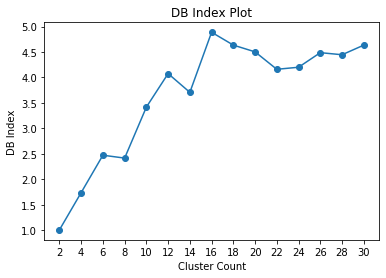

In [22]:
find_optimal_clusters(tfidf, 30)

In [27]:
a_clusters = AgglomerativeClustering(n_clusters=22).fit(tfidf.todense())

In [28]:
get_cluster_counts(a_clusters.labels_)

Cluster 0: 2682
Cluster 1: 928
Cluster 2: 223
Cluster 10: 170
Cluster 4: 110
Cluster 15: 106
Cluster 17: 68
Cluster 5: 63
Cluster 8: 47
Cluster 18: 40
Cluster 16: 39
Cluster 9: 37
Cluster 3: 31
Cluster 7: 31
Cluster 19: 30
Cluster 14: 26
Cluster 6: 24
Cluster 11: 23
Cluster 13: 19
Cluster 12: 16
Cluster 21: 16
Cluster 20: 10


In [29]:
get_top_keywords(tfidf, a_clusters.labels_, vectorizer.get_feature_names(), 10)

Cluster 0:  great, thank, good, people, country, big, president, just, new, job
[0.04316247 0.02605952 0.02041097 0.01937686 0.01804735 0.01781405
 0.01602136 0.01598206 0.01539782 0.01456005]

Cluster 1:  democrats, president, impeachment, trump, democrat, want, say, house, dem, party
[0.0410761  0.03899577 0.03485078 0.03170432 0.03025415 0.02693075
 0.02631599 0.02317627 0.02303357 0.02250253]

Cluster 2:  china, deal, tariff, usa, reserve, dollar, rate, trade, federal, billion
[0.12323064 0.06067751 0.05882611 0.05421835 0.05275261 0.0502024
 0.04730472 0.04613846 0.04588975 0.04535367]

Cluster 3:  thank, maga, work, hard, great, kag, news, soon, year, way
[0.37616911 0.33846521 0.25271285 0.19590867 0.14270141 0.13176752
 0.02895099 0.02397944 0.02216367 0.01940922]

Cluster 4:  schiff, whistleblower, adam, shifty, corrupt, politician, information, fraud, make, release
[0.19480857 0.19164493 0.09307197 0.07830891 0.05890172 0.05372708
 0.04680088 0.04514584 0.03756651 0.03709519]

In [35]:
davies_bouldin_score(tfidf.todense(), a_clusters.labels_)

4.160227974490109

In [30]:
trump['a_cluster'] = a_clusters.labels_
trump.head()

,id,created_at,source,year,month,day,hour,day_of_week,week,is_reply,...,tb_orientation,tb_explanatory,vd_neg,vd_neu,vd_pos,vd_compound,vd_orientation,k_cluster,h_cluster,a_cluster
0,1256024228777857025,Fri May 01 00:54:46 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,negative,subjective,0.373,0.627,0.000,-0.8786,negative,1,-1,0
1,1256016249169084417,Fri May 01 00:23:04 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,positive,subjective,0.205,0.671,0.123,-0.4168,negative,1,-1,0
2,1256013240896835585,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,True,...,positive,objective,0.072,0.740,0.189,0.6885,positive,17,14,0
3,1256013239487549441,Fri May 01 00:11:06 +0000 2020,Twitter for iPhone,2020,4,30,20,4,17,False,...,positive,subjective,0.046,0.640,0.314,0.9439,positive,2,14,0
4,1255926261068763143,Thu Apr 30 18:25:29 +0000 2020,Twitter for iPhone,2020,4,30,14,4,17,False,...,positive,objective,0.000,1.000,0.000,0.0000,neutral,1,14,0


In [137]:
trump.to_csv('trump_clustered.csv', sep=',', encoding='utf-8', index=False)

# LSA

In [51]:
svd_model = TruncatedSVD(n_components=26, algorithm='randomized', n_iter=100, random_state=20)
svd_model.fit(tfidf)

TruncatedSVD(algorithm='randomized', n_components=26, n_iter=100,
             random_state=20, tol=0.0)

In [55]:
terms = vectorizer.get_feature_names()
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print('Topic {}: '.format(i), [t[0] for t in sorted_terms])

Topic 0:  ['thank', 'great', 'job', 'work', 'news', 'maga', 'republican', 'america', 'president', 'house']
Topic 1:  ['great', 'news', 'america', 'president', 'job', 'make', 'country', 'people', 'good', 'fake']
Topic 2:  ['great', 'america', 'job', 'book', 'congratulation', 'honor', 'evening', 'guy', 'maga', 'champion']
Topic 3:  ['news', 'fake', 'medium', 'conference', 'great', 'white', 'story', 'corrupt', 'eastern', 'house']
Topic 4:  ['hunt', 'witch', 'impeachment', 'democrats', 'party', 'great', 'republican', 'schiff', 'transcript', 'hoax']
Topic 5:  ['job', 'endorsement', 'border', 'total', 'complete', 'republican', 'strong', 'maga', 'party', 'crime']
Topic 6:  ['hunt', 'witch', 'good', 'history', 'total', 'country', 'strong', 'continue', 'endorsement', 'china']
Topic 7:  ['party', 'republican', 'approval', 'rating', 'good', '95', 'big', 'record', 'job', 'win']
Topic 8:  ['job', 'president', 'trump', 'true', 'transcript', 'read', 'say', 'great', 'good', 'whistleblower']
Topic 9:  

# LDA

In [80]:
tokens = [list(filter(lambda x: x not in (stop_words), c.split())) for c in corpus]
dictionary = Dictionary(tokens)
dictionary.filter_extremes(no_below=5)
doc2bow = [dictionary.doc2bow(token) for token in tokens]

In [81]:
lda_model = LdaModel(doc2bow, 
                     num_topics=30, 
                     id2word=dictionary, 
                     update_every=5, 
                     chunksize=1000, 
                     passes=5)

In [84]:
lda_model.show_topics(formatted=False, num_words=10, num_topics=30)

[(0,
  [('fake', 0.02509712),
   ('news', 0.023570577),
   ('would', 0.021433307),
   ('party', 0.021380197),
   ('democrat', 0.01652155),
   ('republican', 0.015361649),
   ('medium', 0.013544362),
   ('rating', 0.01091573),
   ('great', 0.010686646),
   ('thank', 0.010329014)]),
 (1,
  [('president', 0.013517501),
   ('never', 0.013189729),
   ('say', 0.012747134),
   ('thank', 0.010589231),
   ('happen', 0.009747411),
   ('get', 0.009294141),
   ('party', 0.009056655),
   ('want', 0.00855373),
   ('house', 0.008502754),
   ('american', 0.007484347)]),
 (2,
  [('great', 0.020733943),
   ('go', 0.01715347),
   ('court', 0.012892072),
   ('come', 0.0124552455),
   ('people', 0.011955367),
   ('new', 0.010216161),
   ('president', 0.009428151),
   ('bad', 0.008934197),
   ('call', 0.008764874),
   ('make', 0.008672234)]),
 (3,
  [('great', 0.062132925),
   ('make', 0.0250203),
   ('america', 0.023415856),
   ('keep', 0.015699673),
   ('country', 0.013698183),
   ('news', 0.013255306),
 